# Example 11: 21cm Sensitivity

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d


import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.history.tla import get_history

import main

## 21-cm Brightness Temperature $T_{21}$ and Matter Temperature $T_m$

21-cm cosmology is one of the most important experimental methods of understanding the thermal and ionization histories of the universe. The global 21-cm brightness temperature is related to the hydrogen spin temperature through the following relation:

$$ T_\text{21} (z) \approx x_\text{HI}(z) \left( \frac{0.15}{\Omega_m} \right)^{1/2} \left( \frac{\Omega_b h}{0.02} \right) \left( \frac{1+z}{10} \right)^{1/2} \left[ 1 - \frac{T_R(z)}{T_S(z)} \right] 23 \text{ mK}, $$

where $x_\text{HI}$ is the neutral fraction of hydrogen, $\Omega_m$ and $\omega_b$ are the matter and baryon energy density as a fraction of the critical density, $h$ is the Hubble parameter today in units of 100 km s$^{-1}$ Mpc$^{-1}$, $T_R$ is the background 21-cm radiation temperature and $T_S$ is the spin temperature. Under standard assumptions, $T_m < T_S < T_\text{CMB}$, where $T_m$ is the matter temperature; this implies that measuring the global 21-cm brightness temperature at a particular redshift sets an upper bound on the matter temperature at that point in time. 

The expected $T_{21}$ assuming no exotic sources of injection is approximately -200 mK at $z \sim 17$. In this notebook, we will use DarkHistory to estimate the limits that can be set on $T_m$, assuming we measure a $T_{21}$ value of -50 mK. We will also compare the difference with and without backreaction taken into account, to give users a sense of the possible differences in constraints.

Before we proceed, we should note that recent measurements performed by the EDGES collaboration <cite data-cite="6232408/FH99AISX"></cite> seems to suggest a $T_{21}(z = 17) \lesssim $ -300 mK at the 99% confidence level, which would suggest that $T_m$ is actually *colder* than expected, assuming that $T_R = T_\text{CMB}$. The introduction of new baryon-DM interactions may be able to produce such an effect, and DarkHistory can be easily modified to accommodate this if desired.

## 21-cm Constraints

First, let's compute the limit set on $T_m$ if we take $T_{21}$ = -50 mK at $z = 17$, assuming that $T_R = T_\text{CMB}$. 

In [4]:
T_21 = -50
rs = 18 # We always define redshifts as 1 + z by convention in the code. 
one_minus_TR_over_TS = (T_21/23.) / (0.15 / phys.omega_m)**0.5 / (phys.omega_baryon*phys.h/0.02) / (rs/10)**0.5
Tm_max = 1/(1 - one_minus_TR_over_TS) * phys.TCMB(rs) / phys.kB # in K
print('The upper bound on Tm is: {:03.1f} K'.format(Tm_max))

The upper bound on Tm is: 20.3 K


### Decaying Dark Matter

Let's first get the constraints for decays. We'll consider two channels: $\chi \to e^+e^-$ and $\chi \to \gamma \gamma$, with no electroweak corrections. To compute the constraints with no backreaction, we can use the tabulated $f_c(z)$ tables, and use these as inputs for [*tla.get_history*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/history/tla/darkhistory.history.tla.get_history.html) and obtain the temperature history. 

With backreaction, however, the spectra of particles that get produced at each redshift step must be computed, and the temperature history integrated as a function of these spectra. This is done by the function [*main.evolve*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). 

For decays, we can specify the primary that we are interested in, the dark matter process, the mass of the dark matter, and the decay lifetime. We also use some coarsening to speed up the calculation. 

We'll define a function called ``get_T_decay`` to run either of these functions, and return the temperature at $z = 17$. 

In [5]:
def get_T_decay(mDM, tau, br, pri):
    """Gets the temperature at z = 17, decays.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    tau : float
        The decay lifetime in s. 
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature in K at z = 17. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 12
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 4
        
    if br:
    
        result = main.evolve(
            primary=pri_str,
            DM_process='decay', mDM=mDM, lifetime=tau,
            start_rs = 3000, end_rs=18,
            coarsen_factor=cf, backreaction=True
        )
        
        return result['Tm'][-1]/phys.kB
    
    else:
        # get_history takes a redshift vector 
        rs_vec = np.flipud(np.arange(18, 3000., 0.1))
        
        result = get_history(
            rs_vec, baseline_f = True,
            inj_particle = pri, DM_process = 'decay',
            mDM=mDM, lifetime = tau
        )
        
        return result[-1,0]/phys.kB

We are now all set up to do the scan. Let's scan over $\chi \to \gamma \gamma$, for $\log_{10} (m_\chi/\text{eV}) \in [4, 12.5] $. We'll do this in a clever way to save the user time here. We'll scan over lifetimes $\log_{10}(\tau/\text{s}) \in [23, 28.5]$, and start with a guess of $10^{25}$ s. Starting from this guess, we compute the matter temperature at $z = 17$. If the temperature lies below `Tm_max`, we will try a shorter lifetime to increase the energy deposition rate, and vice versa with a higher temperature. We'll terminate the scan once we have computed $T_m(z = 17)$ over enough points to linearly interpolate for the lifetime required to produce `Tm_max` at $z = 17$. This lifetime is the *minimum* lifetime allowed by $T_{21} = -$50 mK.

Let's set up a 2D array, indexed by mass and lifetime, one without backreaction, and one with. First specify the decay products, then set up the array.

In [12]:
pri = 'phot'

In [13]:
if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, 0.25)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, 0.25)

log10_tau_arr   = np.arange(23., 28.25, 0.25)

Tm_dec_no_br = np.zeros((log10_m_chi_arr.size, log10_tau_arr.size))
Tm_dec_br = np.zeros_like(Tm_dec_no_br)

Let's start the scan! To do the scan quickly, we'll first run the case with no backreaction first, and then use the results as an initial guess for [*main.evolve*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). 

In [14]:
%autoreload
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    if i==0:
        j = 8
    
    while (
        not below_target or not above_target
    ):

#         print('****************************')
        tau = 10**log10_tau_arr[j]
        
        Tm_dec_no_br[i,j] = get_T_decay(mDM, tau, br=False, pri=pri)
        print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_dec_no_br[i,j]))
             
        if Tm_dec_no_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a shorter lifetime.
            j -= 1
            
        elif Tm_dec_no_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a longer lifetime. 
            j += 1
            
        
#         print('****************************')

print('###### Calculation Complete! ######')           

###### Target Temperature: 20.3 K  ######


****** log10(mDM):  4.01  ******
lifetime: 1.0e+25  T(z = 17) w/o backreaction: 272.6 K
lifetime: 1.8e+25  T(z = 17) w/o backreaction: 168.0 K
lifetime: 3.2e+25  T(z = 17) w/o backreaction: 102.9 K
lifetime: 5.6e+25  T(z = 17) w/o backreaction: 63.3 K
lifetime: 1.0e+26  T(z = 17) w/o backreaction: 39.7 K
lifetime: 1.8e+26  T(z = 17) w/o backreaction: 25.8 K
lifetime: 3.2e+26  T(z = 17) w/o backreaction: 17.7 K
****** log10(mDM):  4.26  ******
lifetime: 1.8e+26  T(z = 17) w/o backreaction: 13.4 K
lifetime: 1.0e+26  T(z = 17) w/o backreaction: 18.4 K
lifetime: 5.6e+25  T(z = 17) w/o backreaction: 26.9 K
****** log10(mDM):  4.51  ******
lifetime: 1.0e+26  T(z = 17) w/o backreaction: 11.6 K
lifetime: 5.6e+25  T(z = 17) w/o backreaction: 15.1 K
lifetime: 3.2e+25  T(z = 17) w/o backreaction: 21.1 K
****** log10(mDM):  4.76  ******
lifetime: 5.6e+25  T(z = 17) w/o backreaction: 12.5 K
lifetime: 3.2e+25  T(z = 17) w/o backreaction: 16.6 K
lifetime: 1.8e+25  T(z = 17) w/o backreaction: 23.5 K
*

Having obtained an (incomplete) list of temperature values, we write a simple function to perform a linear interpolation at each mass point to obtain the limit on the minimum lifetime, and then compute it in `min_lifetime_no_br`. 

In [15]:
def get_log10_min_lifetime(log10_lifetime_arr, Tm_arr, max_Tm):
    """Returns the log10 minimum lifetime from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 lifetimes used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    # Find the last index at which we have Tm > max_Tm in Tm_arr. 
    above = np.where((Tm_arr > 0) & (Tm_arr > max_Tm))[0][-1]
    # Since increasing lifetime decreases Tm, the next index must
    # lie below max_Tm.
    below = above+1
    
    # Obtain the two temperature values. 
    Ts = [Tm_arr[below], Tm_arr[above]]
    # Obtain the two log10 lifetime values. 
    log10_taus = [log10_lifetime_arr[below], log10_lifetime_arr[above]]
    
    # Perform a linear interpolation.
    return (np.diff(log10_taus)/np.diff(Ts)*(max_Tm-Ts[0]) + log10_taus[0])[0]

min_lifetime_no_br = np.array(
    [get_log10_min_lifetime(log10_tau_arr, row, Tm_max) for row in Tm_dec_no_br]
)

Let's just make a simple plot to make sure we understand what we have.

Text(0.5, 0, 'Dark Matter Mass $m_\\chi$ [eV]')

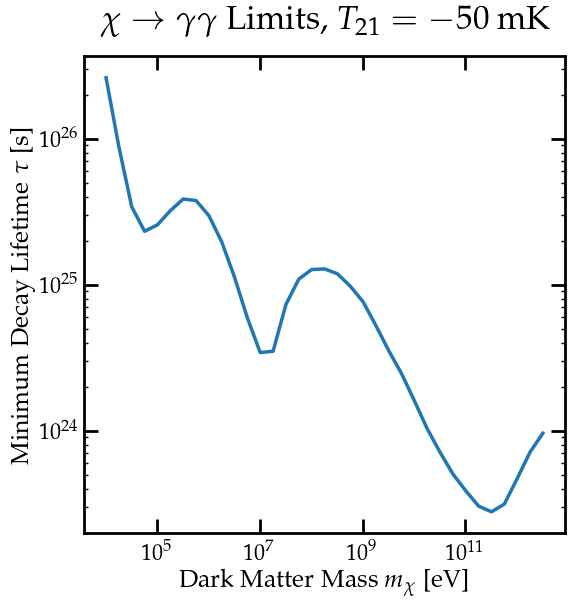

In [16]:
plt.figure()

plt.loglog()

plt.plot(10**log10_m_chi_arr, 10**min_lifetime_no_br)

plt.title(r'$\chi \to \gamma \gamma$ Limits, $T_{21} = -50$ mK')
plt.ylabel(r'Minimum Decay Lifetime $\tau$ [s]')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

Let's do this now with backreaction. The backreaction calculation can be initialized using the $\tau$ value obtained without backreaction as an initial guess. That significantly narrows down the amount of scanning that needs to be done. Otherwise, it works in the same way as before, but it takes longer because the code needs to compute all of the spectra at each step. 

When using *main.evolve* for the first time, the code will take some time to load all of the transfer functions required to perform this calculation.

In [10]:
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    
    # Get the estimate from min_lifetime_no_br
    j = np.where(log10_tau_arr > min_lifetime_no_br[i])[0][0]
    
    while (
        not below_target or not above_target
    ):

#         print('****************************')
        tau = 10**log10_tau_arr[j]
        
        Tm_dec_br[i,j] = get_T_decay(mDM, tau, br=True, pri='phot')
        print('lifetime: {:03.1e}'.format(tau), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_dec_br[i,j]))
             
        if Tm_dec_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a shorter lifetime.
            j -= 1
            
        elif Tm_dec_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a longer lifetime. 
            j += 1
            
        
#         print('****************************')

print('###### Calculation Complete! ######')


###### Target Temperature: 20.3 K  ######


****** log10(mDM):  4.1  ******
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


lifetime: 1.8e+26  T(z = 17) w/o backreaction: 22.0 K


lifetime: 3.2e+26  T(z = 17) w/o backreaction: 15.1 K
****** log10(mDM):  4.35  ******


KeyboardInterrupt: 

### Annihilating Dark Matter

Annihilating dark matter sensitivity can also be evaluated in a very similar manner. The only difference here is that structure formation now boosts the annihilation rate at late times. We can load one of DarkHistory's default structure formation boost factors that can be obtained using the function [*physics.struct_boost_func*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.struct_boost_func.html). The first thing we need to do is obtain the function that returns the boost: 

In [12]:
struct_boost_einasto_subs = phys.struct_boost_func('einasto_with_subs')

We can now define the analogous *get_T_swave* function with this structure formation prescription included with the keyword *struct_boost* passed to [*main.evolve*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html):

In [13]:
%autoreload 2
def get_T_swave(mDM, sigmav, br, pri):
    """Gets the temperature at z = 17, s-wave annihilation.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    sigmav : float
        The annihilation cross-section in cm^-3 s^-1.  
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature in K at z = 17. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 12
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 4
        
    if br:
    
        result = main.evolve(
            primary=pri_str,
            DM_process='swave', mDM=mDM, sigmav=sigmav,
            start_rs = 3000, end_rs=18,
            coarsen_factor=cf, backreaction=True,
            struct_boost=struct_boost_einasto_subs
        )
        
        return result['Tm'][-1]/phys.kB
    
    else:
        # get_history takes a redshift vector 
        rs_vec = np.flipud(np.arange(18, 3000., 0.1))
        
        result = get_history(
            rs_vec, baseline_f = True,
            inj_particle = pri, DM_process = 'swave',
            mDM=mDM, sigmav = sigmav,
            struct_boost=None
        )
        
        return result[-1,0]/phys.kB


Now initialize the data! We use $\langle \sigma v \rangle / m_\chi$ as the range to scan over, since this quantity determines the energy injection rate.

In [ ]:
pri = 'elec'

In [32]:
if pri == 'phot':
    log10_m_chi_arr = np.arange(4, 12.75, 0.25)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, 0.25)
log10_sigmav_over_m_arr   = np.arange(-29, -22, 0.25)

Tm_ann_no_br = np.zeros((log10_m_chi_arr.size, log10_sigmav_over_m_arr.size))
Tm_ann_br = np.zeros_like(Tm_ann_no_br)

And start the scan!

In [33]:
%autoreload
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    if i == 0:
        j = 0
    
    while (
        not below_target or not above_target
    ):

        sigmav = 10**log10_sigmav_over_m_arr[j]*mDM/1e9
        
        Tm_ann_no_br[i,j] = get_T_swave(mDM, sigmav, br=False, pri=pri)
        print('sigmav: {:03.1e}'.format(sigmav), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_ann_no_br[i,j]))
             
        if Tm_ann_no_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a larger sigmav.
            j += 1
            
        elif Tm_ann_no_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a smaller sigmav. 
            j -= 1

print('###### Calculation Complete! ######')

            

###### Target Temperature: 20.3 K  ######


****** log10(mDM):  6.01  ******
sigmav: 1.0e-32  T(z = 17) w/o backreaction: 7.0 K
sigmav: 1.8e-32  T(z = 17) w/o backreaction: 7.2 K
sigmav: 3.2e-32  T(z = 17) w/o backreaction: 7.4 K
sigmav: 5.8e-32  T(z = 17) w/o backreaction: 7.8 K
sigmav: 1.0e-31  T(z = 17) w/o backreaction: 8.5 K
sigmav: 1.8e-31  T(z = 17) w/o backreaction: 9.8 K
sigmav: 3.2e-31  T(z = 17) w/o backreaction: 12.1 K
sigmav: 5.8e-31  T(z = 17) w/o backreaction: 16.1 K
sigmav: 1.0e-30  T(z = 17) w/o backreaction: 23.2 K
****** log10(mDM):  6.26  ******
sigmav: 1.0e-30  T(z = 17) w/o backreaction: 12.7 K
sigmav: 1.8e-30  T(z = 17) w/o backreaction: 17.2 K
sigmav: 3.2e-30  T(z = 17) w/o backreaction: 25.0 K
****** log10(mDM):  6.51  ******
sigmav: 3.2e-30  T(z = 17) w/o backreaction: 13.4 K
sigmav: 5.8e-30  T(z = 17) w/o backreaction: 18.0 K
sigmav: 1.0e-29  T(z = 17) w/o backreaction: 25.9 K
****** log10(mDM):  6.76  ******
sigmav: 1.0e-29  T(z = 17) w/o backreaction: 15.6 K
sigmav: 1.8e-29  T(z = 17) w/o backreactio

As above, we use a simple linear interpolation to determine the maximum $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ over our list of dark matter masses and store the result in `max_xsec_no_br`,

In [34]:
def get_log10_max_xsec(log10_sigmav_over_m_arr, Tm_arr, max_Tm):
    """Returns the log10 maximum sigma v over m from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 sigma v over m's used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    # Find the first index at which we have Tm < max_Tm in Tm_arr. 
    below = np.where((Tm_arr > 0) & (Tm_arr < max_Tm))[0][-1]
    # Since increasing lifetime decreases Tm, the next index must
    # lie below max_Tm.
    above = below+1
    
    # Obtain the two temperature values. 
    Ts = [Tm_arr[below], Tm_arr[above]]
    # Obtain the two log10 lifetime values. 
    log10_xsecs = [log10_sigmav_over_m_arr[below], log10_sigmav_over_m_arr[above]]
    
    # Perform a linear interpolation.
    return (np.diff(log10_xsecs)/np.diff(Ts)*(max_Tm-Ts[0]) + log10_xsecs[0])[0]

max_xsec_no_br = np.array(
    [get_log10_max_xsec(log10_sigmav_over_m_arr, row, Tm_max) for row in Tm_ann_no_br]
)

and then we plot $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ as a function of $m_\chi$

Text(0.5, 0, 'Dark Matter Mass $m_\\chi$ [eV]')

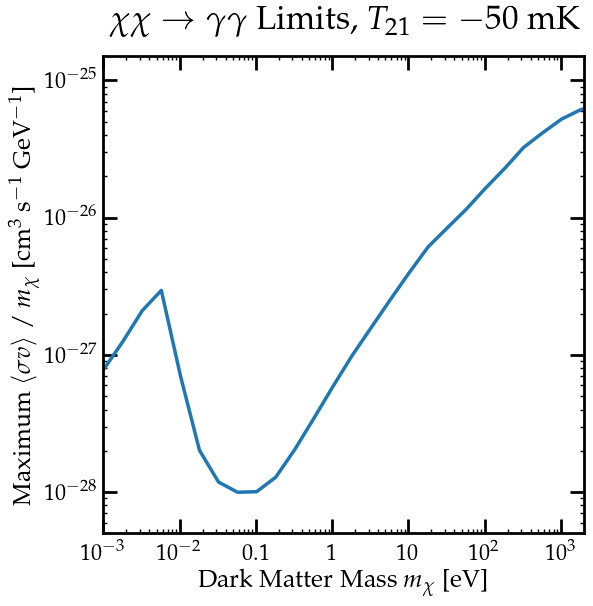

In [39]:
plt.figure()

plt.loglog()

plt.plot(10**log10_m_chi_arr/10**9, 10**(max_xsec_no_br))

if pri == 'phot':
    plt.axis([1e-5,2e3,3e-27,1.5e-25])
else:
    plt.axis([1e-3,2e3,5e-29,1.5e-25])

plt.title(r'$\chi\chi \to \gamma \gamma$ Limits, $T_{21} = -50$ mK')
plt.ylabel(r'Maximum $\langle \sigma v \rangle$ / $m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

and finally compute $\left(\frac{\langle \sigma v \rangle}{m}\right)_\text{max}$ including back-reaction

In [19]:
%autoreload
print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')

for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    
    print('****** log10(mDM): ', log10mDM, ' ******')
    mDM = 10**log10mDM
    
    below_target = False
    above_target = False
    j = np.where(log10_sigmav_over_m_arr > max_xsec_no_br[i])[0][0]
    
    while (
        not below_target or not above_target
    ):

        sigmav = 10**log10_sigmav_over_m_arr[j] * mDM
        
        Tm_ann_br[i,j] = get_T_swave(mDM, sigmav, br=True, pri='phot')
        print('sigmav/m: {:03.1e}'.format(sigmav/mDM), ' T(z = 17) w/ backreaction: {:03.1f} K'.format(Tm_ann_no_br[i,j]))
             
        if Tm_ann_br[i,j] <= Tm_max:
            
            below_target = True
            # Below target T_m means we need a larger sigmav.
            j += 1
            
        elif Tm_ann_br[i,j] >= Tm_max:
            
            above_target = True
            # Above target T_m means we need a smaller sigmav. 
            j -= 1

print('###### Calculation Complete! ######')

###### Target Temperature: 20.3 K  ######


****** log10(mDM):  4.0  ******


sigmav/m: 5.6e-36  T(z = 17) w/o backreaction: 24.4 K


sigmav/m: 3.2e-36  T(z = 17) w/o backreaction: 17.7 K
****** log10(mDM):  4.25  ******


KeyboardInterrupt: 

## Bibliography

<div class="cite2c-biblio"></div>

## Plotting

Specify the type of energy injection and products,

In [18]:
inj_type = 'decay'
pri = 'phot'

then load the raw temperature data as a function of $m_\chi$ and $\tau$ or $\langle \sigma v \rangle$,

In [19]:
user = 'gregoryridgway'
Tm_no_br = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_no_br_v4.p','rb'))
Tm_br = pickle.load(open('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_br_v4.p','rb'))

then process the data to the $\tau$ or $\langle \sigma v \rangle$ bounds as a function of $m_\chi$,

In [27]:
thresh_params_std = np.array(
    [get_log10_min_lifetime(log10_tau_arr, row[pri+'_'+inj_type], Tm_max) for row in Tm_no_br]
)

thresh_params_BR = np.array(
    [get_log10_min_lifetime(log10_tau_arr, row[pri+'_'+inj_type], Tm_max) for row in Tm_br]
)

IndexError: index 1595 is out of bounds for axis 0 with size 1595

### Plots

Make an interpolation function for the points $(m_\text{DM}, \tau_\text{min})$ or $(m_\text{DM}, \sigma_\text{max})$ with and without backreaction.

In [164]:
std_interp = interp1d(log10mDM_arr, thresh_params_std, kind='quadratic')
BR_interp = interp1d(log10mDM_arr, thresh_params_BR, kind='quadratic')

log10mDM_arr_fine = np.arange(log10mDM_arr[0], log10mDM_arr[-1], .01)

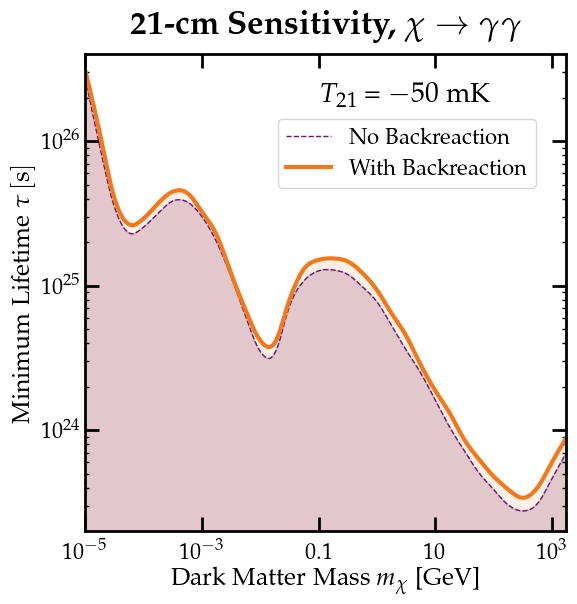

In [166]:
plt.figure()
ax = plt.gca()
ax.loglog()

xmin = 10**log10mDM_arr_fine[0]/1e9
xmax = 10**log10mDM_arr_fine[-1]/1e9

if inj_particle=='electron':
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \chi \to e^+ e^-$')
        ymin = 3e-29
        ymax = 1e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to e^+ e^-$')
        ymin = 1e24
        ymax = 5e28
else:
    if inj_type == 'swave':
        plt.title(r'\bf{21-cm Sensitivity,} $\chi\chi \to \gamma\gamma$')
        ymin = 3e-27
        ymax = 1.5e-25
    else:
        plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma\gamma$')
        ymin = 2e23
        ymax = 4e26
    
plt.xlabel(r'Dark Matter Mass $m_\chi$ [GeV]')
if inj_type == 'swave':
    plt.ylabel(r'Maximum $\langle \sigma v \rangle / m_\chi$ [cm$^3$ s$^{-1}$ GeV$^{-1}$]')
else:
    plt.ylabel(r'Minimum Lifetime $\tau \, [\mathrm{s}]$')
    
plt.axis([xmin, xmax, ymin, ymax])

plt_std, = plt.plot(10**log10mDM_arr_fine/1e9, 10**std_interp(log10mDM_arr_fine), 
        linewidth=1, label='No Backreaction', color='#6a176e', linestyle='--')
plt_BR, = plt.plot(10**log10mDM_arr_fine/1e9, 10**BR_interp(log10mDM_arr_fine), 
         linewidth=3, label='With Backreaction', color='#f37819')

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**std_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='#6a176e',
    alpha=0.2
)

ax.fill_between(
    10**log10mDM_arr_fine/1e9, 
    1e-15, 
    (10**BR_interp(log10mDM_arr_fine)), 
    interpolate=True, 
    color='#f37819',
    alpha=.1
)

if inj_type == 'swave':
    plt.text(0.52, 0.22, r'$T_{21}$ = $-50$ mK', fontsize=20, transform=ax.transAxes) 
else:
    plt.text(0.49, 0.89, r'$T_{21}$ = $-50$ mK', fontsize=20, transform=ax.transAxes)

if inj_type == 'swave':
    if inj_str == 'phot':
        leg = plt.legend(handles=[plt_std, plt_BR])
    else:
        leg = plt.legend(handles=[plt_std, plt_BR], loc='lower right')
else:
    leg = plt.legend(handles=[plt_std, plt_BR], loc=(0.4, 0.72))

# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/'+
#             'DarkHistory_21cm_Sensitivity_'+inj_type+'_'+inj_str+'v2.pdf')